Authors: Hofmarcher

Date: 20-03-2023

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**. 

---


# Imports

Install Gymnasium and dependencies to render the environments

In [1]:
# !apt update
# !apt install -y xvfb x11-utils python-opengl ffmpeg swig
# !pip install gymnasium==0.27.1 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
# !pip install onnx onnx2pytorch==0.4.1

In [2]:
%matplotlib inline

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
from time import time, strftime
from glob import glob
from tqdm import tqdm
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output
from IPython import display

# Select device for training

By default we train on GPU if one is available, otherwise we fall back to the CPU.
If you want to always use the CPU change accordingly.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


# Setup Google Drive mount to store your results

In [4]:
use_google_drive = False
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Download Dataset and Expert model

In [5]:
import os

# Download training and validation datasets

if not os.path.exists('expert.onnx'):
    !wget --no-check-certificate 'https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download' -O expert.onnx

if not os.path.exists('train.zip'):
    !wget --no-check-certificate 'https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download' -O train.zip

if not os.path.exists('val.zip'):
    !wget --no-check-certificate 'https://cloud.ml.jku.at/s/3DxHLiqxTddepp8/download' -O val.zip

# Unzip datasets
if not os.path.exists('train'):
    !unzip -q -o train.zip

if not os.path.exists('val'):
    !unzip -q -o val.zip

# Auxiliary Methods

The following cell contains classes and functions to provide some functionality for logging, plotting and exporting your model in the format required by the submission server.
You are free to use your own logging framework if you wish (such as tensorboard or Weights & Biases).
The logger is a very simple implementation of a CSV-file based logger.
Additionally it creates a folder for each run with subfolders for model files, logs and videos.

In [6]:
class Logger():
    def __init__(self, logdir, params=None):
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")
    
    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))
    
    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None
    
    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


def plot_metrics(logger):
    train_loss  = logger.get_values("training_loss")
    train_entropy  = logger.get_values("training_entropy")
    val_loss = logger.get_values("validation_loss")
    val_acc = logger.get_values("validation_accuracy")
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131, label="train")
    ax2 = fig.add_subplot(131, label="val",frame_on=False)
    ax4 = fig.add_subplot(132, label="entropy")
    ax3 = fig.add_subplot(133, label="acc")

    ax1.plot(train_loss, color="C0")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Update (Training)", color="C0")        
    ax1.xaxis.grid(False)  
    ax1.set_ylim((0,4))

    ax2.plot(val_loss, color="C1")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel('Epoch (Validation)', color="C1")     
    ax2.xaxis.set_label_position('top')     
    ax2.xaxis.grid(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim((0,4))

    ax4.plot(train_entropy, color="C3")    
    ax4.set_xlabel('Update (Training)', color="black")     
    ax4.set_ylabel("Entropy", color="C3")
    ax4.tick_params(axis='x', colors="black")
    ax4.tick_params(axis='y', colors="black")
    ax4.xaxis.grid(False)

    ax3.plot(val_acc, color="C2")
    ax3.set_xlabel("Epoch (Validation)", color="black")
    ax3.set_ylabel("Accuracy", color="C2")
    ax3.tick_params(axis='x', colors="black")
    ax3.tick_params(axis='y', colors="black")
    ax3.xaxis.grid(False)
    ax3.set_ylim((0,1))

    fig.tight_layout(pad=2.0)
    plt.show()
    
"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(video_dir):
    mp4list = glob(f'{video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

# Dataset

Use this dataset class to load the provided demonstrations. Furthermore, this dataset has functionality to add new samples to the dataset which you will need for implementing the DAgger algorithm.

In [7]:
class DemonstrationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob(f"{data_dir}/*.npz"))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        state = data["state"][np.newaxis, ...].astype(np.float32)
        action = data["action"]
        return state / 255.0, action.item()
    
    def append(self, states, actions):
        offset = len(self) + 1
        for i in range(len(states)):
            filename = f"{self.data_dir}/{offset+i:06}.npz"
            np.savez_compressed(filename, state=states[i], action=actions[i].astype(np.int32))
            self.files.append(filename)

# Inspect data

It is always a good idea to take a look at the data when you start working with a new dataset. Feel free to investigate the dataset further on your own.

In [8]:
# Action Statistics
dataset = DemonstrationDataset("train")
print("Number of samples: {}".format(len(dataset)));

Number of samples: 49538


Action: steer left


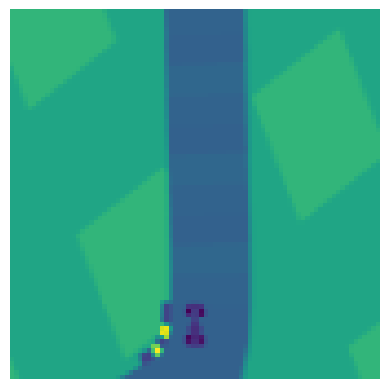

In [9]:
# Action mapping from gymnasium.farama.org
action_mapping = {
    0: "do nothing",
    1: "steer left",
    2: "steer right",
    3: "gas",
    4: "brake"
}

# Visualize random frames
idx = np.random.randint(len(dataset))
state, action = dataset[idx]
# store a single frame as we need it later for exporting an ONNX model (it needs a sample of the input for the export)
sample_state = torch.Tensor(state).unsqueeze(0).to(device)
# Display the sample
print(f"Action: {action_mapping[action]}")
plt.axis("off")
plt.imshow(state[0]);

In [10]:
# release memory
del dataset

# Define Policy Network

You need to design a neural network architecture that is capable of mapping a state to an action.
The input is a single image with the following properties:
- Resolution of 84x84 pixels
- Grayscale (meaning a single channel as opposed to three channels of an RGB image)
- The values of each pixel should be between 0 and 1

The output of the network should be one unit per possible action, as our environment has 5 actions that results in 5 output units.
Your network must implement the forward function in order to be compatible with the evaluation script.

In [11]:
import torchvision

class PolicyNetwork(nn.Module):
    def __init__(self, n_units_out):
        super(PolicyNetwork, self).__init__()
        
        # make initialization reproducibles
        torch.random.manual_seed(42)
        self.eff_net = torchvision.models.efficientnet_b0(weights=None, num_classes=n_units_out)
        assert isinstance(self.eff_net, torchvision.models.EfficientNet)
        
        first_conv = self.eff_net.features[0][0]
        assert isinstance(first_conv, torch.nn.Conv2d)
        self.eff_net.features[0][0] = torch.nn.Conv2d(
            in_channels=1, # make the architecture accept a single (grayscale) channel
            out_channels=first_conv.out_channels,
            kernel_size=first_conv.kernel_size,
            stride=first_conv.stride,
            padding=first_conv.padding,
            bias=first_conv.bias is not None,
        )

        # last_linear = self.eff_net.classifier[-1]
        # assert isinstance(last_linear, torch.nn.Linear)
        # self.eff_net.classifier[-1] = torch.nn.Linear(
        #     in_features=last_linear.in_features,
        #     out_features=n_units_out,
        #     bias=last_linear.bias is not None,
        # )

    def forward(self, x) -> torch.Tensor:
        return self.eff_net(x)

# Train behavioral cloning policy

Now that you have a Dataset and a network you need to train your network.
With behavioral cloning we want to imitate the behavior of the agent that produced the demonstration dataset as close as possible.
This is basically supervised learning, where you want to minimize the loss of your network on the training and validation sets.

Some tips as to what you need to implement:
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- don't forget to evaluate your network on the validation set
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

In [12]:
# ! pip install lovely-tensors
# ! pip install lightning

In [13]:
from tqdm.notebook import tqdm

# choose the batchsize for training
batch_size = 128

# Datasets
train_set = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=8, shuffle=False, drop_last=False, pin_memory=True)

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
# You can also choose to use a different logging framework such as tensorboard (not recommended on Colab) or Weights & Biases (highly recommended)
#logger = Logger("logdir")
#print("Saving state to {}".format(logger.basepath))


######################
### YOUR CODE HERE ###
######################


import pathlib
from typing import Tuple, Dict

import lovely_tensors
import lightning
import lightning.pytorch.loggers
import lightning.pytorch.callbacks


class LightningPolicyNetwork(lightning.LightningModule):
    
    def __init__(self, action_mapping: Dict[int, str], use_augment: bool):
        super().__init__()
        self.save_hyperparameters()
        self.use_augment = use_augment
        self.action_mapping = action_mapping
        self.n_actions = len(action_mapping)

        self.model = PolicyNetwork(self.n_actions)
        self.loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

        self.augment = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)), # convert single-channel grayscale to RGB
            torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            torchvision.transforms.RandomResizedCrop(size=sample_state.shape[-2:], scale=(0.9, 1)),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.RandomErasing(p=0.8, scale=(0, 0.01), value="random"),
            torchvision.transforms.Grayscale(num_output_channels=1),
        ])

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx):
        state, action = batch
        if self.use_augment:
            state = self.augment(state)
        logits: torch.Tensor = self(state)
        loss = torch.nn.functional.cross_entropy(logits, action)
        entropy = -(logits.softmax(dim=-1) * logits.log_softmax(dim=-1)).sum(dim=-1).mean()
        self.log("train/loss", loss)
        self.log("train/entropy", entropy)
        return loss
    
    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx):
        state, action = batch
        logits: torch.Tensor = self(state)
        loss = torch.nn.functional.cross_entropy(logits, action)
        entropy = -(logits.softmax(dim=-1) * logits.log_softmax(dim=-1)).sum(dim=-1).mean()
        accuracy = (logits.argmax(dim=-1) == action).float().mean()
        self.log_dict({
            "valid/accuracy": accuracy,
            "valid/loss": loss,
            "valid/entropy": entropy,
        })
        return loss


wandb_logger = lightning.pytorch.loggers.WandbLogger(
    project="jku-deep-rl_imitation-learning",
    save_dir="wandb",
)

early_stopping = lightning.pytorch.callbacks.EarlyStopping(
    monitor="valid/accuracy",
    patience=5,
    mode="max",
    min_delta=0.01,
)

checkpointing = lightning.pytorch.callbacks.ModelCheckpoint(
    monitor="valid/accuracy",
    mode="max",
    save_top_k=3,
    save_last=True,
    dirpath=f"checkpoints/{wandb_logger.experiment.name}/",
    filename="epoch={epoch}_step={step}_valid-accuracy={valid/accuracy:.2f}",
    auto_insert_metric_name=False,
)

lightning_model = LightningPolicyNetwork(action_mapping=action_mapping, use_augment=True)
trainer = lightning.Trainer(
    logger=[wandb_logger],
    val_check_interval=0.5,
    max_epochs=20,
    precision="16-mixed",
    callbacks=[early_stopping, checkpointing],
)

wandb: Currently logged in as: markcheeky. Use `wandb login --relogin` to force relogin


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | PolicyNetwork    | 4.0 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.054    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
lightning_model = LightningPolicyNetwork.load_from_checkpoint(checkpointing.best_model_path)
model = lightning_model.model

In [16]:
# If you want to export your model as an ONNX file use the following code as template
# If you use the provided logger you can use this directly
save_as_onnx(
    model.to("cpu"),
    sample_state.to("cpu"),
    pathlib.Path(checkpointing.best_model_path).with_suffix(".onnx"),
)

# Evaluate the agent in the real environment

### Environment and Agent

We provide some wrappers you need in order to get the same states from the environment as in the demonstration dataset.
Additionally the `RecordState` wrapper should be very helpful in collecting new samples for the DAgger algorithm.

In [ ]:
class CropObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        gym.ObservationWrapper.__init__(self, env)
        self.shape = shape
        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return observation[:self.shape[0], :self.shape[1]]

    
class RecordState(gym.Wrapper):
    def __init__(self, env: gym.Env, reset_clean: bool = True):
        gym.Wrapper.__init__(self, env)

        assert env.render_mode is not None
        self.frame_list = []
        self.reset_clean = reset_clean

    def step(self, action, **kwargs):
        output = self.env.step(action, **kwargs)
        self.frame_list.append(output[0])
        return output

    def reset(self, *args, **kwargs):
        result = self.env.reset(*args, **kwargs)

        if self.reset_clean:
            self.frame_list = []
        self.frame_list.append(result[0])

        return result

    def render(self):
        frames = self.frame_list
        self.frame_list = []
        return frames
    

class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):        
        with torch.no_grad():
            state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
            logits = self.model(state)
            if type(logits) is tuple:
                logits = logits[0]
            probs = Categorical(logits=logits)
            return probs.sample().cpu().numpy()[0]
        
            
def make_env(seed, capture_video=True):
    env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir)
            
    env = CropObservation(env, (84, 96))
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)    
    env = RecordState(env, reset_clean=True)
    env = gym.wrappers.FrameStack(env, 4)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def run_episode(agent, show_progress=True, capture_video=True, seed=None):
    env = make_env(seed=seed, capture_video=capture_video)
    state, _ = env.reset()
    score = 0
    done = False
    if show_progress:
        progress = tqdm(desc="Score: 0")
        
    while not done:
        action = agent.select_action(state[-1][np.newaxis, ...])
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))       
    env.close()
    
    if show_progress:
        progress.close()    
    if capture_video:
        show_video(logger.video_dir)
    
    return score

## Evaluate behavioral cloning agent

Let's see how the agent is doing in the real environment

In [ ]:
train_policy = Agent(model, device)
score = run_episode(train_policy, show_progress=True, capture_video=True);
print(f"Score: {score:.2f}")

Since we often have high variance when evaluating RL agents we should evaluate the agent multiple times to get a better feeling for its performance.

In [ ]:
train_policy = Agent(model, device)
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [ ]:
# Load expert
expert_model = ConvertModel(onnx.load("expert.onnx"))
expert_model = expert_model.to(device)
# Freeze expert weights
for p in expert_model.parameters():
    p.requires_grad = False
    
expert_policy = Agent(expert_model, device)

Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

In [ ]:
# inner loop of DAgger
def dagger(env, train_policy, expert_policy, dataset, beta=1.):
    
    ######################
    ### YOUR CODE HERE ###
    ######################
    
    # Implement DAgger algorithm here
    # 1) Choose a policy (sample according to beta)
    # 2) Sample T-step trajectory with the chosen policy 
    #    (T can be an entire episode or a single state, think about what makes more sense here and implement it accordingly)
    # 3) Label the state (or states) with your expert if they come from your training policy
    
    #### Note ####
    # To get an action for the current state from your training policy or expert policy:
    # action = policy.select_action(state) 
    # 
    # Your training policy requires a single grayscale state while 
    # the expert policy requires four stacked grayscale states
    # You can prepare your state for the policy like so:
    # Train policy: 
    #      np.expand_dims(state[-1], 0)
    # Expert policy:
    #      state
    
    
    # Due to the RecordState wrapper you can get the states from the environment by calling 
    # env.render()
    # Doing so will clear the list and the next time you call .render() will return the new states since the last call.
    # Note: be careful with the last state
    
    # Finally, add collected states and the actions the expert would execute in them to the dataset
    # dataset.append(states, actions)

Put everything together now. 
1. Create new samples using the DAgger algorithm
2. Continue training your agent
3. Export your fully trained agent as an ONNX file

In [ ]:
# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
logger = Logger("logdir_dagger")
print("Saving state to {}".format(logger.basepath))

# start environment
env = make_env(seed=42, capture_video=False)

# Training
######################
### YOUR CODE HERE ###
######################

save_as_onnx(model, sample_state, logger.onnx_file)
env.close()

In [ ]:
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))